## Make sure that Data can be loaded and transformed

In [1]:
from omegaconf import OmegaConf
import os
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Define Transformations (Resize + Normalize)
config = OmegaConf.load('configs/train.yaml')
transform = transforms.Compose([
    transforms.Resize((config.model.image_size, config.model.image_size)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1,1]
])


In [3]:

config = OmegaConf.load("configs/train.yaml")

transform = transforms.Compose(
    [
        transforms.Resize(
            (config.model.image_size, config.model.image_size)
        ),  # Resize images to 64x64
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1,1]
    ]
)


class PokemonDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = self.get_valid_images(image_folder)
        self.transform = transform

    def get_valid_images(self, folder):
        valid_images = []
        for f in os.listdir(folder):
            if f.endswith(".png"):
                img_path = os.path.join(folder, f)
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify if the image is corrupted
                    valid_images.append(f)
                except (IOError, UnidentifiedImageError):
                    print(f"Skipping corrupted file: {f}")
        return valid_images

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [4]:

# Load Dataset
dataset = PokemonDataset("data/raw/", transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, num_workers=8, pin_memory=True, shuffle=True)

dataloader = DataLoader(dataset, batch_size=8, num_workers=os.cpu_count() // 2, pin_memory=True, shuffle=True)



## Basic version of a forward pass

In [5]:
import torch
import numpy as np

In [6]:
class NoiseScheduler:
    '''
    We define βₜ (the noise variance) and αₜ (related to βₜ):

    βₜ (beta_t) controls how much noise is added at each step.
    αₜ (alpha_t) and ᾱₜ (cumulative alpha) determine the transition from x₀ to xₜ.
    '''
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.num_timesteps = num_timesteps
        self.device = device  # Store device info

        # Initialize tensors
        self.beta_t = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alpha_t = 1.0 - self.beta_t
        self.alpha_bar_t = torch.cumprod(self.alpha_t, dim=0)

    def get_variance(self, t):
        """Returns beta_t and alpha_bar_t at timestep t (ensuring they're on the correct device)."""
        return self.beta_t[t], self.alpha_bar_t[t]

# Initialize Scheduler
scheduler = NoiseScheduler(num_timesteps=1000)

In [7]:
def forward_diffusion(x_0, t, scheduler):
    """Adds noise to image x_0 at timestep t"""
    beta_t, alpha_bar_t = scheduler.get_variance(t)
    # Ensure `alpha_bar_t` has the right shape for broadcasting
    alpha_bar_t = alpha_bar_t.view(-1, 1, 1, 1)  # Reshape to [batch_size, 1, 1, 1]

    beta_t, alpha_bar_t = beta_t.to(x_0.device), alpha_bar_t.to(x_0.device)

    noise = torch.randn_like(x_0, device=x_0.device)  # Sample Gaussian noise
    
    # Apply diffusion
    noisy_x = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    return noisy_x, noise  # Return both the noisy image and the actual noise

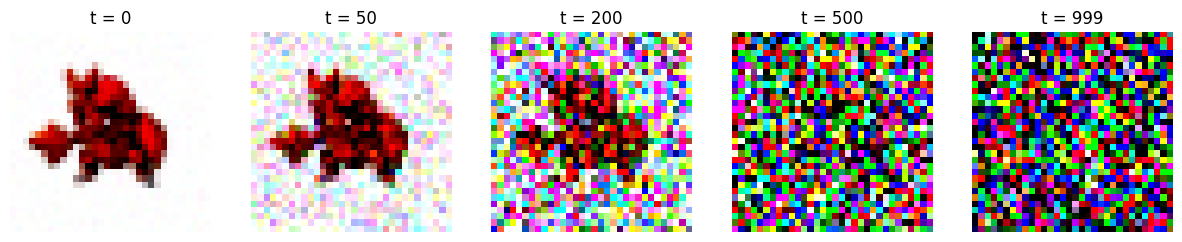

In [8]:
# Select a sample image from the dataset
sample_image = dataset[0].unsqueeze(0)  # Add batch dimension

# Pick timesteps to visualize
timesteps = [0, 50, 200, 500, 999]

plt.figure(figsize=(15, 3))
for i, t in enumerate(timesteps):
    noisy_image, _ = forward_diffusion(sample_image, t, scheduler)
    noisy_image = noisy_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert to displayable format
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure valid pixel values

    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t = {t}")

plt.show()

## Define the U-Net model for denoising

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# Net v3 with batch normalization
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Encoding path
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # BatchNorm after conv1
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  # BatchNorm after conv2
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)  # BatchNorm after conv3

        # Bottleneck
        self.conv_mid = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_mid = nn.BatchNorm2d(256)  # BatchNorm in bottleneck

        # Decoding path
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.bn_deconv3 = nn.BatchNorm2d(128)  # BatchNorm in decoder
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.bn_deconv2 = nn.BatchNorm2d(64)  # BatchNorm in decoder
        
        self.deconv1 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        x1 = F.relu(self.bn1(self.conv1(x)))  # (3 → 64)
        x2 = F.relu(self.bn2(self.conv2(F.max_pool2d(x1, 2))))  # (64 → 128)
        x3 = F.relu(self.bn3(self.conv3(F.max_pool2d(x2, 2))))  # (128 → 256)

        # Bottleneck
        x_mid = F.relu(self.bn_mid(self.conv_mid(F.max_pool2d(x3, 2))))  # (256 → 256)

        # Decoder (skip connections)
        x_up3 = F.relu(self.bn_deconv3(self.deconv3(x_mid)))  # (256 → 128)
        x_up2 = F.relu(self.bn_deconv2(self.deconv2(x_up3)))  # (128 → 64)
        x_up1 = self.deconv1(x_up2)  # (64 → 3)
        x_up1 = torch.tanh(x_up1)  # Ensure output is in [-1,1]

        # Ensure output size matches input
        x_up1 = F.interpolate(x_up1, size=(32, 32), mode='bilinear', align_corners=False)

        return x_up1


## Train the model to predict the noise

In [11]:
from src.utils.preprocess import preprocess
from src.models.unet import UNet

In [12]:
import torch.optim as optim
# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleUNet().to(device)
model = UNet(in_channels=3).to(device)
scheduler = NoiseScheduler(num_timesteps=1000, device=device)

# Move scheduler's tensors to the correct device
scheduler.beta_t = scheduler.beta_t.to(device)
scheduler.alpha_t = scheduler.alpha_t.to(device)
scheduler.alpha_bar_t = scheduler.alpha_bar_t.to(device)

optimizer = optim.Adam(model.parameters(), weight_decay=1e-4, lr=1e-4) # 1e-3 was causing exploding weights
criterion = nn.MSELoss()  # Predicting noise, so we use MSE loss


In [13]:

# Define checkpoint directory
checkpoint_dir = "src/models/"
os.makedirs(checkpoint_dir, exist_ok=True)

# Save model
def save_model(model, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

def load_model(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()  # Set to evaluation mode
    print(f"Loaded model from {checkpoint_path}")
    return model



In [14]:
# Training Loop
num_epochs = 10  # Keep it small for now

# Define checkpoint directory
checkpoint_dir = "src/models/"
os.makedirs(checkpoint_dir, exist_ok=True)



for epoch in range(num_epochs):
    for batch_idx, imgs in enumerate(dataloader):
        imgs = imgs.to(device)
        # Sample a random timestep for each image
        t = torch.randint(0, scheduler.num_timesteps, (imgs.shape[0],), device=device)
        # Apply forward diffusion
        noisy_imgs, noise = forward_diffusion(imgs, t, scheduler)
        # Predict noise using U-Net
        noise_pred = model(noisy_imgs, 100)
        
        
        # Compute loss
        loss = criterion(noise_pred, noise)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5) 
        optimizer.step()

        # Print loss occasionally
        if batch_idx % 1000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    save_model(model, epoch)


AttributeError: 'dict' object has no attribute 'size'

In [ ]:
import os
import glob
import numpy as np
import torchvision.utils as vutils
from tqdm import tqdm

# Configuration
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
image_size = 32  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to find the latest checkpoint
def find_latest_checkpoint(checkpoint_dir):
    checkpoints = glob.glob(os.path.join(checkpoint_dir, "model_epoch_*.pth"))
    if not checkpoints:
        raise FileNotFoundError("No checkpoints found!")
    latest_checkpoint = max(checkpoints, key=os.path.getctime)
    return latest_checkpoint

# Load latest model
latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
model = SimpleUNet().to(device)
model.load_state_dict(torch.load(latest_checkpoint, map_location=device))
model.eval()
print(f"Loaded model from {latest_checkpoint}")
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"NaN detected in {name}")

# Sampling process
def generate_images(num_samples=8):
    with torch.no_grad():
        # Start with pure noise
        x_t = torch.randn((num_samples, 3, image_size, image_size), device=device)
        
        for t in tqdm(reversed(range(scheduler.num_timesteps))):
            beta_t, alpha_bar_t = scheduler.get_variance(t)

            if torch.isnan(beta_t).any() or torch.isnan(alpha_bar_t).any():
                print(f"NaN detected in scheduler at timestep {t} -> beta_t: {beta_t}, alpha_bar_t: {alpha_bar_t}")
                break  # Stop execution immediately

            noise_pred = model(x_t)

            if torch.isnan(noise_pred).any():
                print(f"NaN detected in model output at timestep {t}")
                break

            # x_t = (x_t - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)

            # Avoid dividing by 0 error
            eps = 1e-7  # Small constant to prevent instability
            x_t = (x_t - torch.sqrt(torch.clamp(1 - alpha_bar_t, min=eps)) * noise_pred) / torch.sqrt(torch.clamp(alpha_bar_t, min=eps))
            if x_t.abs().max() > 1e3:  # Arbitrary threshold, adjust as needed
                print(f"Warning: x_t exploding at timestep {t}, max value: {x_t.abs().max().item()}")
                break

            if torch.isnan(x_t).any():
                print(f"NaN detected in x_t at timestep {t}")
                break

            if t > 0:
                noise = torch.randn_like(x_t)
                # x_t += torch.sqrt(beta_t) * noise
                # avoid dividing by 0 error
                x_t += torch.sqrt(torch.clamp(beta_t, min=eps)) * noise

        
        # Normalize images to [0,1]
        generated_images = (x_t + 1) / 2  # Assuming tanh output
        print("Min:", generated_images.min().item(), "Max:", generated_images.max().item())

        return generated_images



Loaded model from src/models/model_epoch_9.pth


In [ ]:

# Generate images
samples = generate_images(num_samples=8)
vutils.save_image(samples, os.path.join(output_dir, "generated_samples.png"))
print(f"Generated samples saved to {output_dir}/generated_samples.png")

1it [00:00, 112.75it/s]

Min: -41792.23046875 Max: 43228.390625
Generated samples saved to results/generated_samples.png
